In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [4]:
#Load the dataset

df = pd.read_csv('/content/online_retail.csv')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
11699,537262,21930,JUMBO STORAGE BAG SKULLS,1,2010-12-06 11:26:00,1.95,15039.0,United Kingdom
11700,537262,22382,LUNCH BAG SPACEBOY DESIGN,1,2010-12-06 11:26:00,1.65,15039.0,United Kingdom
11701,537262,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,1,2010-12-06 11:26:00,3.25,15039.0,United Kingdom
11702,537262,15056N,EDWARDIAN PARASOL NATURAL,3,2010-12-06 11:26:00,5.95,15039.0,United Kingdom


In [5]:
# Check with their are null values or not

df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,42
Quantity,0
InvoiceDate,0
UnitPrice,1
CustomerID,3503
Country,1


In [6]:
#Step 3 — Data Cleaning
#Missing CustomerID
#Returns (negative Quantity)
#Cancelled invoices (InvoiceNo starts with C)

# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative quantities
df = df[df['Quantity'] > 0]

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [7]:
#Feature Engineering
#Create total spend per transaction.
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']



In [8]:
#RFM Analysis (Core Segmentation Method)

'''RFM =
Recency → Last purchase date
Frequency → Number of purchases
Monetary → Total spend'''

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()



,Recency,Frequency,Monetary
CustomerID,,,
12395.0,3,1,346.10
12427.0,4,1,303.50
12431.0,6,1,358.25
12433.0,5,1,1919.14
12472.0,1,1,1631.30


In [9]:
#Scale Features

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [10]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.groupby('Cluster').mean()


,Recency,Frequency,Monetary
Cluster,,,
0,1.664179,1.268657,447.117463
1,4.650273,1.109290,361.338907
2,3.000000,4.200000,5721.256000
3,4.000000,34.000000,5391.210000


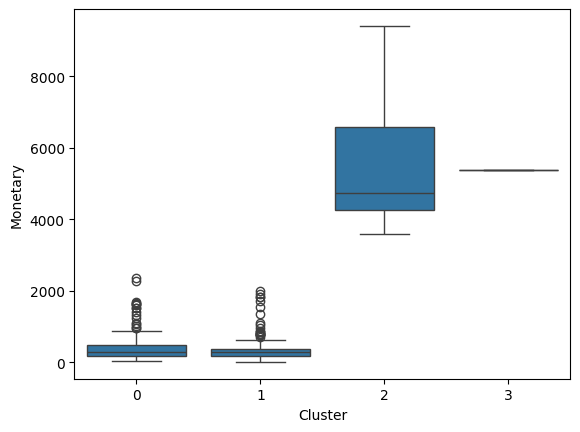

In [11]:
# Interpret Segments

sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.show()


In [12]:
# Retention Analysis (Cohort)

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

cohort = df.groupby(['CustomerID'])['InvoiceMonth'] \
           .min() \
           .reset_index()

cohort.columns = ['CustomerID', 'CohortMonth']

df = df.merge(cohort, on='CustomerID')


In [13]:
#Cohort Index

df['CohortIndex'] = (
    (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month) + 1
)


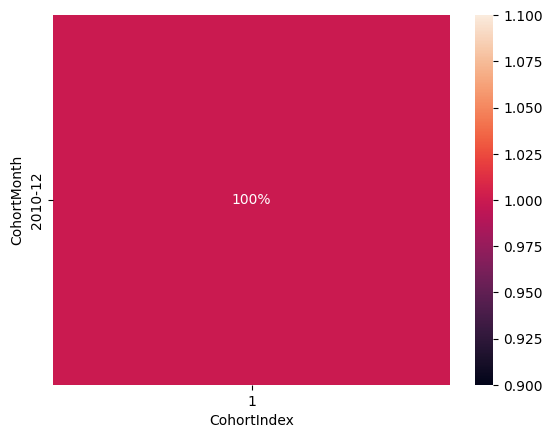

In [14]:
# Retention Table

cohort_data = df.groupby(['CohortMonth','CohortIndex']) \
                ['CustomerID'] \
                .nunique() \
                .reset_index()

cohort_pivot = cohort_data.pivot(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

sns.heatmap(retention, annot=True, fmt='.0%')
plt.show()
